# Chapter 11 - The Linear Regression

## Listing 11-1. Importing the data and plotting it

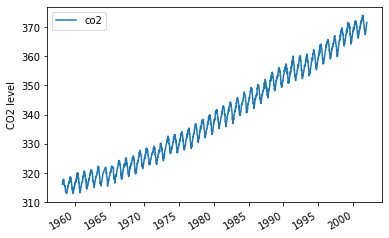

In [91]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

data = sm.datasets.co2.load_pandas()
co2 = data.data
co2 = co2.dropna()
ax = co2.plot()
ax.set_ylabel('CO2 level')
plt.show()


In [94]:
co2.asfreq='w'
co2
co2.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-17', '1958-05-24',
               '1958-07-05', '1958-07-12',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2225, freq=None)

In [63]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [64]:
adf_test(co2)

Augmented Dickey-Fuller Test: 
ADF test statistic         0.043965
p-value                    0.962020
# lags used               27.000000
# observations          2197.000000
critical value (1%)       -3.433330
critical value (5%)       -2.862856
critical value (10%)      -2.567471
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Listing 11-2. Creating the variable month

In [95]:
co2['month'] = [x.month for x in co2.index] 

C:\Users\hansh\AppData\Local\Temp/ipykernel_12684/27764350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2['month'] = [x.month for x in co2.index]


## Listing 11-3. Creating the variable year

In [96]:
co2['year'] = [x.year for x in co2.index] 

C:\Users\hansh\AppData\Local\Temp/ipykernel_12684/3206968955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2['year'] = [x.year for x in co2.index]


In [67]:
co2.head()

,co2,month,year
1958-03-29,316.1,3,1958
1958-04-05,317.3,4,1958
1958-04-12,317.6,4,1958
1958-04-19,317.5,4,1958
1958-04-26,316.4,4,1958


In [68]:
from pmdarima.arima import auto_arima
help(auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arima`` [3].


In [97]:
from sklearn.model_selection import train_test_split
variables=['month','year']
X=co2[variables]
y=co2['co2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12345,shuffle=False)

In [70]:
model=auto_arima(y_test,X_test,start_p=0, start_q=0,m=52)

KeyboardInterrupt: 

In [98]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  445
Model:               SARIMAX(3, 0, 5)   Log Likelihood                -284.021
Date:                Wed, 08 Jun 2022   AIC                            592.042
Time:                        22:45:37   BIC                            641.219
Sample:                    06-26-1993   HQIC                           611.433
                         - 12-29-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0970     10.104      0.010      0.992     -19.706      19.900
month          0.0142      0.045      0.315      0.753      -0.075       0.103
year           0.1772      0.577      0.307      0.759      -0.954       1.308
ar.L1          0.8796      0.132      6.658      0.000       0.621       1.139
ar.L2          0.9720      0.230      4.223      0.000       0.521       1.423
ar.L3         -0.8605      0.117     -7.335      0.000      -1.090      -0.631
ma.L1          0.0374      0.136      0.274      0.784      -0.230       0.305
ma.L2         -0.8286      0.126     -6.561      0.000      -1.076      -0.581
ma.L3          0.2948      0.054      5.424      0.000       0.188       0.401
ma.L4          0.2136      0.055      3.877      0.000       0.106       0.322
ma.L5          0.0330      0.053      0.619      0.536      -0.071       0.137
sigma2         0.2075      0.013     16.344      0.000       0.183       0.232
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                14.76
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.03
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [99]:
mod = sm.tsa.arima.ARIMA(y_train, X_train,order=(3, 0, 5))
results=mod.fit()
residuals=results.resid

C:\Users\hansh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hansh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hansh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hansh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [100]:
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff as diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import jarque_bera as jb
from itertools import combinations
import seaborn as sns

In [101]:
def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
    
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
    
    Lags should be min(2*seasonal_period, T/5)
    
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
    
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(ljung(x=residuals, lags=lags).iloc[:,1])
    norm_p_val =  jb(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
    
    
    
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", np.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3), "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")

** Mean of the residuals:  0.0

** Ljung Box Test, p-value: 0.018 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


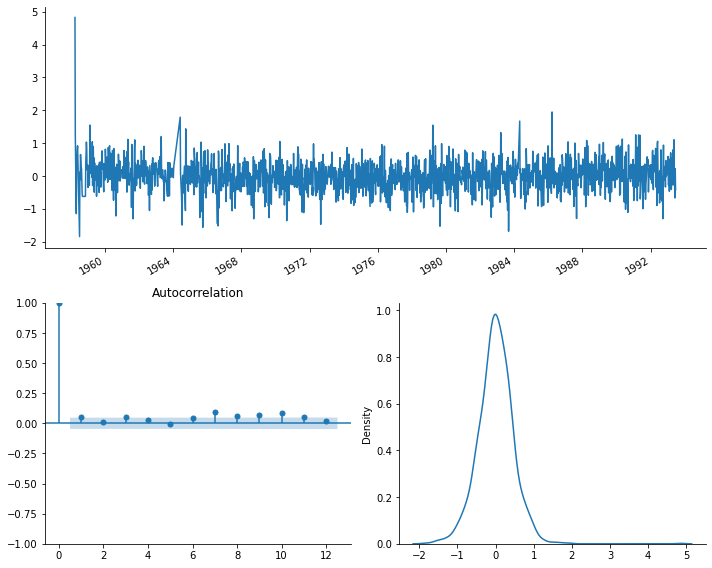

In [102]:
import numpy as np
residcheck(residuals,12)

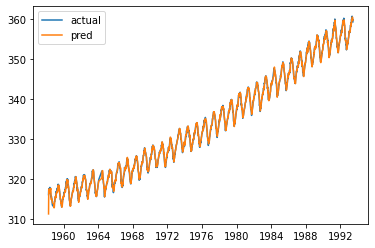

In [112]:
from sklearn.metrics import r2_score
pred_train=results.fittedvalues
plt.plot(y_train,label="actual")
plt.plot(pred_train,label='pred')
plt.legend()
plt.show()

In [113]:
r2_score(y_train,pred_train)

0.9987226617995342

In [124]:
len(y_train)

1780

In [130]:
start_index = len(y_train)
end_index = len(y_train)+len(y_test)-1

In [132]:
pred_test=results.predict(start=len(y_train),end=end_index,exog=X_test)

C:\Users\hansh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [133]:
r2_score(y_test,pred_test)

0.2745135601671932

## Listing 11-4. Fitting a Linear Regression with two variables

0.9690528910892238 0.3433251233952809


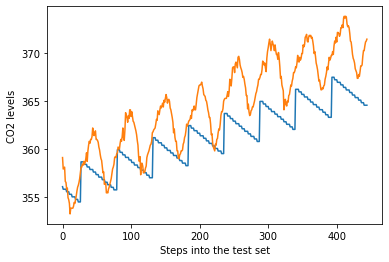

In [134]:
# Create X and y objects
X = co2[['year', 'month']]
y = co2['co2']

# Create Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12345,shuffle=False)

# Fit model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

my_lm = LinearRegression()
my_lm.fit(X = X_train, y = y_train)

train_fcst = my_lm.predict(X_train)
test_fcst = my_lm.predict(X_test)

train_r2 = r2_score(y_train, train_fcst)
test_r2 = r2_score(y_test, test_fcst)

print(train_r2, test_r2)

# Plot result
plt.plot(list(test_fcst))
plt.plot(list(y_test))
plt.xlabel('Steps into the test set')
plt.ylabel('CO2 levels')
plt.show()


## Listing 11-4. Adding lagged variables into the data

In [135]:
co2['co2_l1'] = co2['co2'].shift(1)
co2['co2_l2'] = co2['co2'].shift(2)
co2['co2_l3'] = co2['co2'].shift(3)
co2['co2_l4'] = co2['co2'].shift(4)
co2['co2_l5'] = co2['co2'].shift(5)


C:\Users\hansh\AppData\Local\Temp/ipykernel_12684/3081521428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2['co2_l1'] = co2['co2'].shift(1)
C:\Users\hansh\AppData\Local\Temp/ipykernel_12684/3081521428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2['co2_l2'] = co2['co2'].shift(2)
C:\Users\hansh\AppData\Local\Temp/ipykernel_12684/3081521428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

## Listing 11-5. Drop missing values

In [136]:
co2 = co2.dropna()

## Listing 11-6. Fitting the full Linear Regression model

In [149]:
# Create X and y objects
X = co2[['year', 'month', 'co2_l1', 'co2_l2', 'co2_l3']]
y = co2['co2']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12345,shuffle=False)
train=pd.concat([X_train,y_train],axis=1)



0.9991385542518157 0.993427182073524


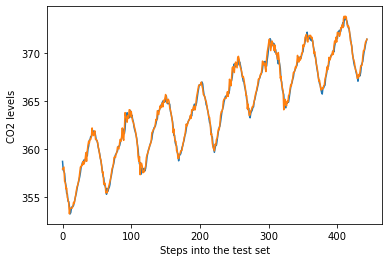

In [151]:
# Fit the model
my_lm = smf.ols("co2 ~ year+C(month)+co2_l1+co2_l2+co2_l3", data=train).fit()

train_fcst = my_lm.predict(X_train)
test_fcst = my_lm.predict(X_test)

train_r2 = r2_score(y_train, train_fcst)
test_r2 = r2_score(y_test, test_fcst)

print(train_r2, test_r2)

# Plot result
plt.plot(list(test_fcst))
plt.plot(list(y_test))
plt.xlabel('Steps into the test set')
plt.ylabel('CO2 levels')
plt.show()


In [138]:
train_r2 = r2_score(y_train, train_fcst)
test_r2 = r2_score(y_test, test_fcst)

In [139]:
train_r2

0.9986189935237852

In [140]:
test_r2

0.9891589480449011

In [153]:
import statsmodels.formula.api as smf
smf.ols("co2 ~ year+C(month)+co2_l1+co2_l2+co2_l3", data=train).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-44.5478,12.083,-3.687,0.000,-68.246,-20.849
C(month)[T.2],-0.0420,0.046,-0.922,0.357,-0.131,0.047
C(month)[T.3],0.0842,0.045,1.866,0.062,-0.004,0.173
C(month)[T.4],0.1361,0.047,2.884,0.004,0.044,0.229
C(month)[T.5],-0.1084,0.048,-2.242,0.025,-0.203,-0.014
C(month)[T.6],-0.5762,0.050,-11.495,0.000,-0.675,-0.478
C(month)[T.7],-0.8795,0.051,-17.409,0.000,-0.979,-0.780
C(month)[T.8],-1.0622,0.050,-21.394,0.000,-1.160,-0.965
C(month)[T.9],-0.8718,0.050,-17.461,0.000,-0.970,-0.774
C(month)[T.10],-0.2146,0.046,-4.672,0.000,-0.305,-0.125
